# Generación de Imágenes a partir de Texto usando MLX

Este notebook demuestra cómo generar imágenes a partir de texto utilizando Stable Diffusion con optimización MLX para Apple Silicon.

## Setup

In [4]:
import mlx.core as mx
import mlx.nn as nn
from stable_diffusion import StableDiffusion
from PIL import Image
import numpy as np
from tqdm import tqdm


## Cargar el Modelo

Utilizaremos Stable Diffusion 2.1 optimizado para MLX. El modelo se descargará automáticamente en la primera ejecución.

In [3]:
# Inicializar el modelo usando MLX Stable Diffusion
model = StableDiffusion(
    "stabilityai/stable-diffusion-2-1-base",
    float16=True
)

# Opcional: Cuantizar el modelo para mejor rendimiento
nn.quantize(model.text_encoder, class_predicate=lambda _, m: isinstance(m, nn.Linear))
nn.quantize(model.unet, group_size=32, bits=8)

# Asegurar que los modelos estén cargados en memoria
model.ensure_models_are_loaded()

# Establecer número de pasos de inferencia
n_steps = 50
cfg_weight = 7.5

## Crear Función de Generación de Imágenes

In [4]:
def generate_image(prompt, num_steps=20):
    """Generar una imagen a partir de un texto prompt"""
    latents = model.generate_latents(
        prompt,
        num_steps=num_steps
    )
    
    # Evaluar los latents
    for x_t in latents:
        mx.eval(x_t)
    
    # Decodificar a imagen
    decoded = model.decode(x_t)
    mx.eval(decoded)
    
    # Convertir a PIL
    # El modelo ya devuelve valores normalizados en [0, 1]
    image_array = np.array(decoded[0] * 255).astype(np.uint8)
    image = Image.fromarray(image_array)
    
    return image

## Probar la Implementación

Vamos a generar una imagen con un prompt de prueba:

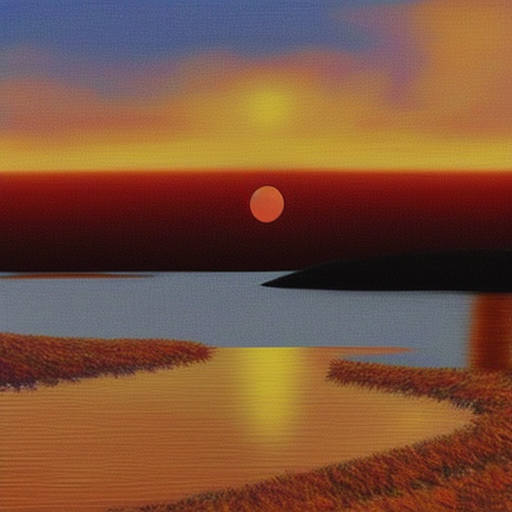

In [5]:
test_prompt = "Una hermosa puesta de sol sobre las montañas, estilo arte digital"
generated_image = generate_image(test_prompt)
display(generated_image)

## Configuración Avanzada de Generación

Implementemos una función más avanzada que permita controlar:
- Número de imágenes a generar
- Tamaño de la imagen
- Seed para reproducibilidad
- Guidance scale (influencia del prompt)
- Negative prompts

In [6]:
def generate_advanced(prompt,
                     negative_prompt=None,
                     num_images=1,
                     height=512,
                     width=512,
                     num_steps=20,
                     guidance_scale=7.5,
                     seed=None):
    """Función avanzada de generación de imágenes"""
    latents = model.generate_latents(
        prompt,
        n_images=num_images,
        num_steps=num_steps,
        cfg_weight=guidance_scale,
        negative_text=negative_prompt,
        seed=seed,
    )
    
    for x_t in tqdm(latents, total=num_steps):
        mx.eval(x_t)
    
    decoded = model.decode(x_t)
    mx.eval(decoded)
    
    image_arrays = np.array(decoded * 255).astype(np.uint8)
    images = [Image.fromarray(arr) for arr in image_arrays]
    return images

## Función de Visualización

Agregemos una función para mostrar múltiples imágenes en una cuadrícula:

In [7]:
def display_images(images, cols=2):
    """Muestra múltiples imágenes en una cuadrícula"""
    import math
    from matplotlib import pyplot as plt
    
    rows = math.ceil(len(images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()
    
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    
    for i in range(len(images), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

## Ejemplo Avanzado

Generemos múltiples variaciones con diferentes parámetros:

100%|██████████| 30/30 [00:23<00:00,  1.26it/s]


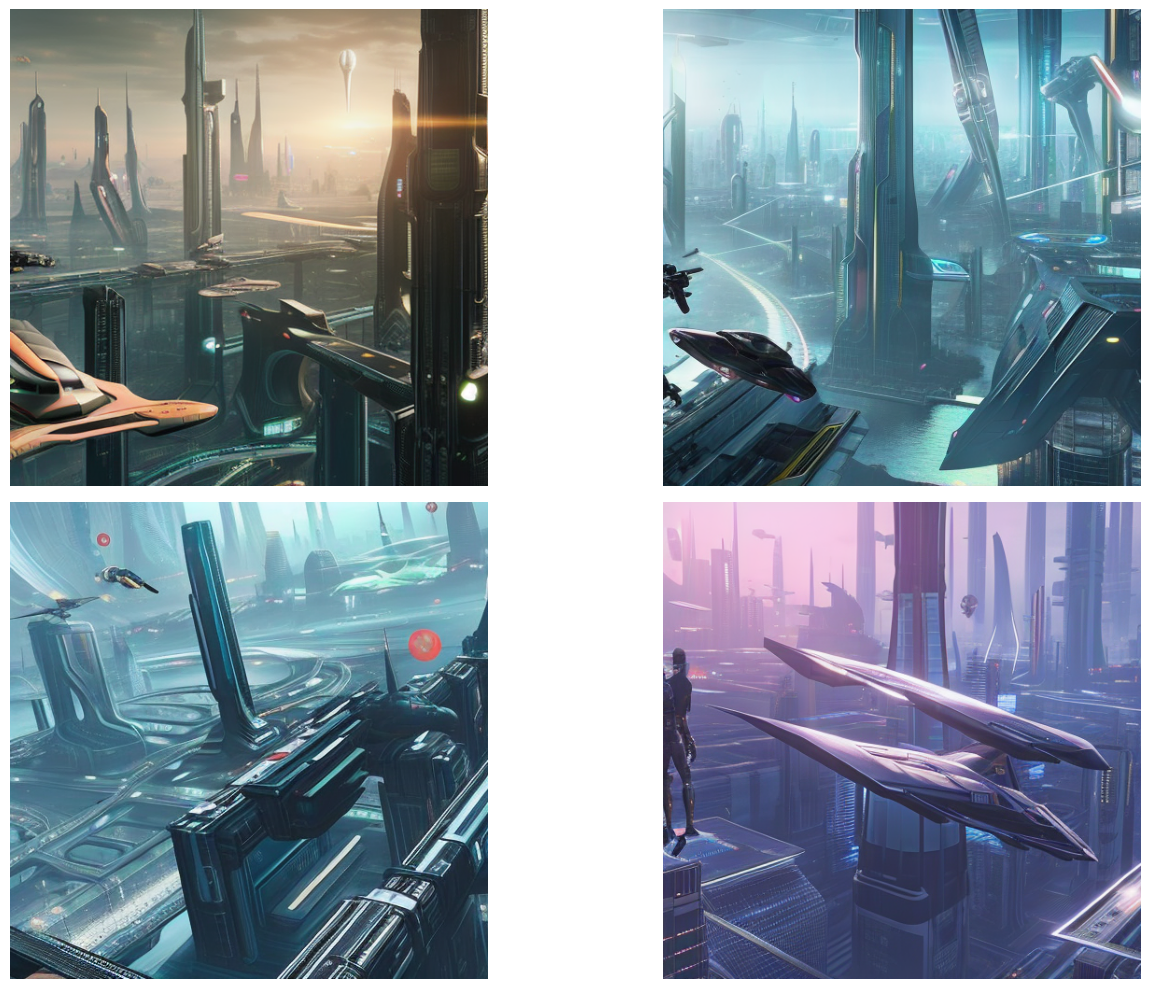

In [13]:
# Ejemplo con parámetros avanzados
prompt = "Un dragón místico volando sobre una ciudad futurista, estilo cyberpunk"
negative_prompt = "borroso, desenfocado, baja calidad, distorsionado"

images = generate_advanced(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_images=4,
    height=512,
    width=512,
    num_steps=30,
    guidance_scale=8.5,
    seed=42
)

display_images(images)